In [1]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [49]:
arquivo_raster = '/Users/marcelofernandes/My Drive/Arquivos/h_max_1.34953e+08_pacote100_090924.tif'

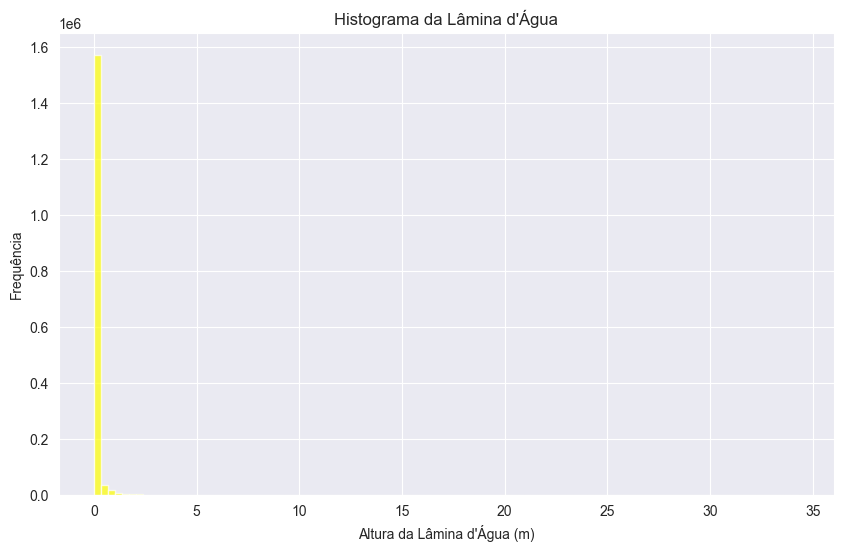

    Intervalo Inferior (m)  Intervalo Superior (m)  Frequência  Percentual (%)
0                 0.000000                0.343056     1571798         95.6496
1                 0.343056                0.686112       36206          2.2033
2                 0.686112                1.029168       15104          0.9191
3                 1.029168                1.372224        7175          0.4366
4                 1.372224                1.715280        3470          0.2112
..                     ...                     ...         ...             ...
95               32.590313               32.933369           0          0.0000
96               32.933369               33.276424           0          0.0000
97               33.276424               33.619480           0          0.0000
98               33.619480               33.962536           0          0.0000
99               33.962536               34.305592           2          0.0001

[100 rows x 4 columns]


In [64]:
# Definindo o limite de altura
limite_minimo = 0 # em metros
limite_maximo = 35 # em metros

# Número de intervalos (bins) do histograma
numero_bins = 100

# Abrindo o arquivo raster
with rasterio.open(arquivo_raster) as src:
    # Lendo a primeira banda do raster
    banda1 = src.read(1)

    # Obtendo o valor "NoData" do raster
    no_data_value = src.nodata
    
    # Criando uma máscara para filtrar os valores "NoData"
    if no_data_value is not None:
        mask = banda1 != no_data_value
        banda1 = banda1[mask]

    #Filtrando os valores acima de 30 cm e abaixo do limite máximo
    banda1_filtrada = banda1[(banda1 >= limite_minimo) & (banda1 <= limite_maximo)]

    # Criando o histograma
    plt.figure(figsize=(10, 6))
    plt.hist(banda1_filtrada.flatten(), bins=numero_bins, color='yellow', alpha=0.7)
    plt.title('Histograma da Lâmina d\'Água')
    plt.xlabel('Altura da Lâmina d\'Água (m)')
    plt.ylabel('Frequência')
    plt.grid(True)
    plt.show()
    
    # Gerando o histograma
    counts, bin_edges = np.histogram(banda1_filtrada, bins=numero_bins)
    
    # Calculando o percentual de cada intervalo em relação ao total de pixels filtrados
    total_pixels = counts.sum()
    porcentagens = np.round((counts / total_pixels) * 100,4) # Formatando para quatro casas decimais
    
    # Criando a tabela com os dados do histograma
    tabela_histograma = pd.DataFrame({
        'Intervalo Inferior (m)': bin_edges[:-1],
        'Intervalo Superior (m)': bin_edges[1:],
        'Frequência': counts,
        'Percentual (%)': porcentagens
    })

    # Exibindo a tabela
    print(tabela_histograma)

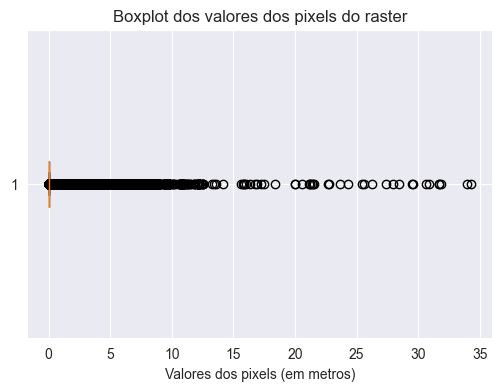

In [65]:
# Transformar o raster em uma lista de valores (1D) para criar o boxplot
pixel_values = banda1_filtrada.flatten()

# Criar o boxplot
plt.figure(figsize=(6, 4))
plt.boxplot(pixel_values, vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title("Boxplot dos valores dos pixels do raster")
plt.xlabel("Valores dos pixels (em metros)")
plt.show()


In [60]:
from scipy.ndimage import generic_filter

# Função para calcular os outliers com base no IQR
def detect_outliers(data):
    Q1 = np.percentile(data, 25)
    print("Q1: ", round(Q1,2))
    Q3 = np.percentile(data, 75)
    print("Q3: ",round(Q3,2))
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    #upper_bound = Q3 + 1.5 * IQR
    upper_bound = 0.3
    return (data < lower_bound) | (data > upper_bound)

In [61]:
# Exibir os valores que foram marcados como outliers
#print("Valores outliers:", banda1_filtrada[detect_outliers(banda1_filtrada)])
pixel_outliers = banda1_filtrada[detect_outliers(banda1_filtrada)]
print('Total de pixels: ', len(pixel_values))
print(f'Total de pixels outliers: {len(pixel_outliers)} ou {len(pixel_outliers)/len(pixel_values)*100:.2f}%')

Q1:  0.0
Q3:  0.01
Total de pixels:  1643287
Total de pixels outliers: 79836 ou 4.86%


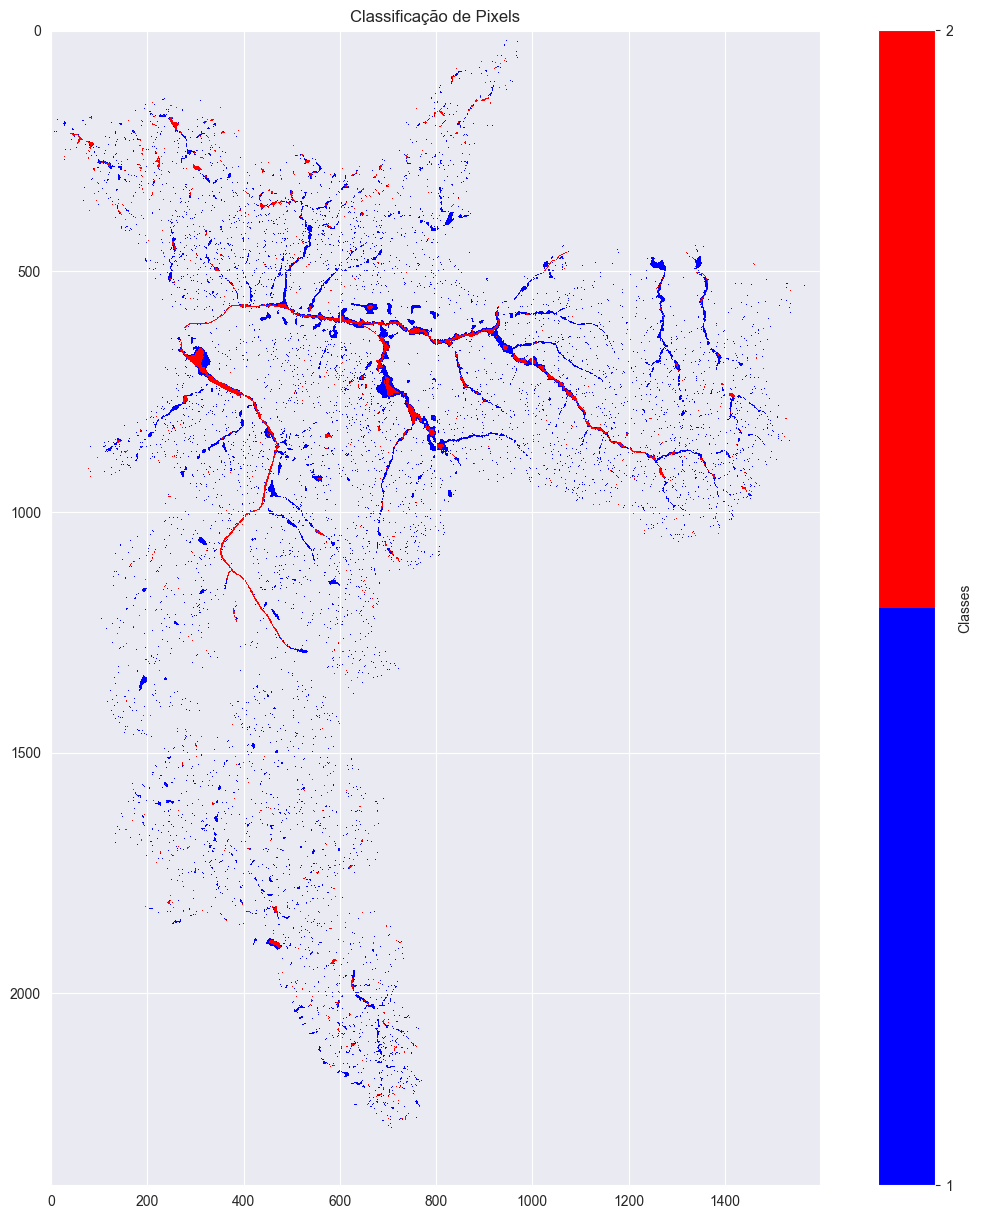

In [77]:
from matplotlib.colors import ListedColormap

# Abrindo o arquivo raster
with rasterio.open(arquivo_raster) as src:
    # Lendo a primeira banda do raster
    banda1 = src.read(1)

    # Obtendo o valor "NoData" do raster
    no_data_value = src.nodata
    
    # O erro TypeError: Invalid shape (1643290,) for image data ocorre porque, após aplicar a máscara banda1 = banda1[mask], o array resultante (banda1) se torna unidimensional (1D), mas a função plt.imshow() espera uma matriz 2D para visualizar corretamente uma imagem raster.
    
    # Criando uma máscara para filtrar os valores "NoData"
    if no_data_value is not None:
        mask = banda1 != no_data_value
    else:
        mask = np.ones_like(banda1, dtype=bool)  # Se não houver valor NoData, considerar todos os valores
    
    # Aplicar máscara para garantir que apenas valores válidos sejam considerados
    banda1_filtrada = np.where(mask, banda1, np.nan)  # Colocar NaN onde há NoData
    
   # Criar uma matriz de classificação
    classified_pixels = np.full(banda1_filtrada.shape, np.nan)  # Matriz vazia com NaN

    # Pixels entre 1m e 2m serão classificados como 1
    classified_pixels[(banda1_filtrada > 0.3) & (banda1_filtrada <= 1)] = 1

    # Pixels maiores que 2m serão classificados como 2
    classified_pixels[banda1_filtrada > 1] = 2

    # Criar um colormap personalizado
    cmap = ListedColormap(['blue', 'red'])  # Azul para classe 1, Vermelho para classe 2
    
    # Plotar o gráfico
    plt.figure(figsize=(15, 15))
    plt.imshow(classified_pixels, cmap=cmap, interpolation='none')
    plt.colorbar(ticks=[1, 2], label='Classes')  # Definir as classes no colorbar
    plt.title('Classificação de Pixels')
    
    # Exibir o gráfico
    plt.show()

In [25]:
# Função para processar o pixel (central e vizinhos)
def process_pixel(values):
    if len(values) == 9:  # Certifica que estamos lidando com uma matriz 3x3 completa
        center_value = values[4]  # Valor central da matriz 3x3
        neighbors = np.concatenate([values[:4], values[5:]])  # Vizinhos
        if detect_outliers(np.array([center_value])):  # Se for outlier
            neighbor_mean = np.mean(neighbors)
            if abs(center_value - neighbor_mean) > 1.5 * np.std(neighbors):  # Se for muito diferente dos vizinhos
                return neighbor_mean  # Substitui pelo valor médio dos vizinhos
    return values[len(values) // 2]  # Retorna o valor central, mesmo se a janela for menor que 3x3

In [26]:
# Aplicar o filtro sobre o raster usando uma janela 3x3
processed_raster = generic_filter(banda1_filtrada, process_pixel, size=3, mode='reflect')

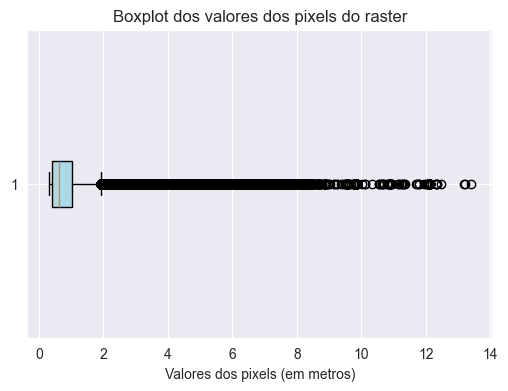

In [27]:
# Transformar o raster em uma lista de valores (1D) para criar o boxplot
pixel_values2 = processed_raster.flatten()

# Criar o boxplot
plt.figure(figsize=(6, 4))
plt.boxplot(pixel_values2, vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title("Boxplot dos valores dos pixels do raster")
plt.xlabel("Valores dos pixels (em metros)")
plt.show()

In [10]:
# Remover valores de no data se houver
no_data_value = src.nodata
if no_data_value is not None:
    raster = np.ma.masked_equal(raster, no_data_value)

In [12]:
# Criando o histograma
plt.figure(figsize=(10, 6))
plt.hist(raster.flatten(), bins=50, color='blue', alpha=0.7)
plt.title('Histograma da Lâmina d\'Água')
plt.xlabel('Altura da Lâmina d\'Água (m)')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()

NameError: name 'raster' is not defined

<Figure size 1000x600 with 0 Axes>

In [ ]:
# Carregar a imagem raster
dataset_raster = rasterio.open(arquivo_raster)
dataset_raster.meta
# Ajustar o sistema de coordendas da rede
edges2_proj_utm = edges2_proj.to_crs(epsg=31983)
edges2_proj_utm.crs
import rasterio
import numpy as np

# Carregar o raster
with rasterio.open(arquivo_raster) as src:
    raster = src.read(1)
    raster_transform = src.transform



# Calcular estatísticas descritivas
mean_value = np.mean(raster)
median_value = np.median(raster)
std_dev = np.std(raster)
min_value = np.min(raster)
max_value = np.max(raster)
percentiles = np.percentile(raster, [25, 50, 75])

# Exibir os resultados
print(f'Média: {mean_value}')
print(f'Mediana: {median_value}')
print(f'Desvio Padrão: {std_dev}')
print(f'Valor Mínimo: {min_value}')
print(f'Valor Máximo: {max_value}')
print(f'Percentil 25: {percentiles[0]}')
print(f'Percentil 50: {percentiles[1]}')
print(f'Percentil 75: {percentiles[2]}')

# TODO Calcular a média sem os no-value
import geopandas as gpd
import rasterio
from shapely.geometry import box
from shapely.ops import split
import multiprocessing

# Carregar o raster
raster = rasterio.open(arquivo_raster)
'''
# Obter as dimensões do raster
ncols, nrows = raster.width, raster.height
xmin, ymin, xmax, ymax = raster.bounds
xres = (xmax - xmin) / ncols
yres = (ymax - ymin) / nrows

# Criar uma lista de polígonos representando os pixels do raster
polygons = []
for i in range(nrows):
    for j in range(ncols):
        x1 = xmin + j * xres
        x2 = x1 + xres
        y1 = ymax - i * yres
        y2 = y1 - yres
        polygons.append(box(x1, y1, x2, y2))

# Criar um GeoDataFrame a partir dos polígonos
grid_gdf = gpd.GeoDataFrame({'geometry': polygons}, crs=edges2.crs)
'''
'''
def segment_line_with_grid(line, grid):
    segments = []
    for polygon in grid.geometry:
        intersection = line.intersection(polygon)
        if not intersection.is_empty:
            if intersection.geom_type == 'LineString':
                segments.append((intersection, polygon))
            elif intersection.geom_type == 'MultiLineString':
                for seg in intersection:
                    segments.append((seg, polygon))
    return segments
    '''
'''def process_line_chunks(lines_chunk, grid_gdf):
    segmented_lines = []
    for line in lines_chunk:
        segmented_lines.extend(segment_line_with_grid(line, grid_gdf))
    return segmented_lines

# Função para dividir o GeoDataFrame em chunks
def chunkify(df, n):
    return [df[i::n] for i in range(n)]

# Dividir as linhas em chunks
num_cores = multiprocessing.cpu_count()
chunks = chunkify(edges2_proj_utm.geometry, num_cores)

# Criar um pool de processos e processar os chunks
with multiprocessing.Pool(num_cores) as pool:
    results = pool.starmap(process_line_chunks, [(chunk, grid_gdf) for chunk in chunks])

# Combinar os resultados dos chunks
segmented_lines = [item for sublist in results for item in sublist]

# Criar um novo GeoDataFrame com as linhas segmentadas
segmented_geometries = [seg[0] for seg in segmented_lines]
segmented_values = [seg[1].value for seg in segmented_lines]
segmented_gdf = gpd.GeoDataFrame({'geometry': segmented_geometries, 'value': segmented_values}, crs=edges2_proj_utm.crs)

'''
'''
# Intersectar a rede viária com os polígonos do grid
segmented_roads = gpd.overlay(edges2_proj_utm, grid_gdf, how='intersection')

# Garantir que as linhas segmentadas não se transformem em polígonos
segmented_roads = segmented_roads.explode(index_parts=False).reset_index(drop=True)'''
import geopandas as gpd
from shapely.geometry import LineString, MultiLineString


def redistribute_vertices(geom, distance):
    if geom.geom_type == 'LineString':
        num_vert = int(round(geom.length / distance))
        if num_vert == 0:
            num_vert = 1
        return LineString(
            [geom.interpolate(float(n) / num_vert, normalized=True)
             for n in range(num_vert + 1)])
    elif geom.geom_type == 'MultiLineString':
        parts = [redistribute_vertices(part, distance)
                 for part in geom]
        return type(geom)([p for p in parts if not p.is_empty])
    else:
        raise ValueError('unhandled geometry %s', (geom.geom_type,))


def segmentize_gdf(gdf, distance):
    new_geometries = []
    new_attributes = []

    for idx, row in gdf.iterrows():
        geom = row.geometry
        attributes = row.drop('geometry')

        redistributed = redistribute_vertices(geom, distance)

        if redistributed.geom_type == 'LineString':
            for i in range(len(redistributed.coords) - 1):
                segment = LineString([redistributed.coords[i], redistributed.coords[i + 1]])
                new_geometries.append(segment)
                new_attributes.append(attributes)
        elif redistributed.geom_type == 'MultiLineString':
            for part in redistributed:
                for i in range(len(part.coords) - 1):
                    segment = LineString([part.coords[i], part.coords[i + 1]])
                    new_geometries.append(segment)
                    new_attributes.append(attributes)

    new_gdf = gpd.GeoDataFrame(new_attributes, geometry=new_geometries, crs=gdf.crs)
    return new_gdf


import time

start_time = time.time()
# Segmentar a rede viária em intervalos de 10m
segmented_edges2 = segmentize_gdf(edges2_proj_utm, 10)
end_time = time.time()

execution_time = end_time - start_time
print(f'Segmentized edges2: {execution_time:.2f} segundos')
print(f'O total de linhas originais é {edges2_proj_utm.shape[0]} linhas')
print(f'Já o método de quebra produziu {segmented_edges2.shape[0]} linhas')
import geopandas as gpd
from shapely.geometry import Point, LineString


def extract_nodes_from_segments(gdf):
    nodes = set()
    for line in gdf.geometry:
        coords = list(line.coords)
        nodes.add(Point(coords[0]))
        nodes.add(Point(coords[-1]))
    return list(nodes)


# Extraímos os nós dos segmentos da rede segmentada
nodes = extract_nodes_from_segments(segmented_edges2)

# Criar um GeoDataFrame para os nós
nodes_gdf = gpd.GeoDataFrame(geometry=nodes, crs=segmented_edges2.crs)


def create_edges_from_segments(gdf):
    edges = []
    for idx, row in gdf.iterrows():
        line = row['geometry']
        coords = list(line.coords)
        start_node = Point(coords[0])
        end_node = Point(coords[-1])
        edge_attributes = row.drop('geometry').to_dict()  # Excluir a geometria para adicionar os atributos restantes
        edge_attributes['geometry'] = line  # Adicionar a geometria novamente como shapely object
        edge_attributes['start'] = start_node  # Adicionar o nó de início
        edge_attributes['end'] = end_node  # Adicionar o nó de término
        edges.append(edge_attributes)
    return edges


# Criar arestas a partir dos segmentos da rede segmentada
edges = create_edges_from_segments(segmented_edges2)

# Criar um GeoDataFrame para as arestas com todos os atributos de segmented_edges2
edges_gdf = gpd.GeoDataFrame(
    edges,  # A lista de dicionários de atributos
    geometry='geometry',
    crs=segmented_edges2.crs
)

# Verificar se os atributos foram transferidos corretamente
print(edges_gdf.info())
import matplotlib.pyplot as plt

# Criar uma figura para plotar os nós e as arestas
fig, ax = plt.subplots(figsize=(10, 10))

# Plotar as arestas
edges_gdf.plot(ax=ax, color='red', linewidth=0.5, label='Arestas')

# Plotar os nós
nodes_gdf.plot(ax=ax, color='yellow', markersize=10, label='Nós')

# Adicionar título e legenda
ax.set_title('Rede de Nós e Arestas da Rede Segmentada')
ax.legend()

# Ajustar a visualização
ax.set_axis_off()

plt.tight_layout()
plt.show()

# Identificar os componentes fortemente conectados (SCCs)
sccs = list(nx.strongly_connected_components(G3))

# Encontrar a maior SCC com base no número de nós
largest_scc = max(sccs, key=len)

# Criar um subgrafo contendo apenas a maior SCC
subgraph_scc = G3.subgraph(largest_scc)

'''
import matplotlib.pyplot as plt

# Função para desenhar o grafo
def plot_graph(G, ax, node_color='yellow', node_size=10, edge_color='black', edge_linewidth=0.5):
    pos = {node: node for node in G.nodes()}
    nx.draw(G, pos, ax=ax, node_color=node_color, node_size=node_size,
            edge_color=edge_color, width=edge_linewidth, with_labels=False)

# Criar uma figura e eixos para plotar os grafos
fig, ax = plt.subplots(figsize=(15, 8))

# Plotar o grafo original
plot_graph(G3, ax=ax, node_color='yellow', node_size=00, edge_color='yellow', edge_linewidth=0.5)

# Plotar o subgrafo da maior SCC
plot_graph(subgraph_scc, ax=ax, node_color='red', node_size=0, edge_color='red', edge_linewidth=1.0)

# Adicionar título ao plot
fig.suptitle("Rede Segmentada Sobreposta à Maior SCC", fontsize=16)

# Adicionar uma legenda manualmente
yellow_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=10, label='Rede Original')
red_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Maior SCC')

# Colocar a legenda no gráfico
plt.legend(handles=[yellow_patch, red_patch], loc='upper right')

# Mostrar o plot
plt.show()
'''
# Criar o plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plotar o raster
show(dataset_raster, ax=ax, cmap='viridis', alpha=0.9)

# Plotar a rede viária
edges_gdf.plot(ax=ax, color='lightgray')

# Configurar título e eixos
ax.set_title('Rede Viária sobre Raster de Alagamento')
plt.show()
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show

# Definir os limites para o zoom (em coordenadas EPSG:31983)
# Substitua estes valores pelos limites desejados
zoom_min_x = 347500  # Coordenada mínima x
zoom_max_x = 350500  # Coordenada máxima x
zoom_min_y = 7389500  # Coordenada mínima y
zoom_max_y = 7392000  # Coordenada máxima y

# Criar o plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plotar o raster
show(dataset_raster, ax=ax, cmap='viridis', alpha=0.9)

# Adicionar contornos
#contours = ax.contour(dataset_raster, levels=np.arange(0,9, 1), colors='black')
#ax.clabel(contours, inline=True, fontsize=8)

# Plotar a rede viária
edges_gdf.plot(column='speed_kph_maparadar', ax=ax, cmap='viridis')

# Ajustar os limites dos eixos para dar zoom
ax.set_xlim(zoom_min_x, zoom_max_x)
ax.set_ylim(zoom_min_y, zoom_max_y)

# Configurar título e eixos
ax.set_title('Rede Viária sobre Raster de Alagamento com Zoom')
plt.show()

# TODO tentar segmentar a rede pelo tamanho pixel (FEITO)